In [70]:
from database.market import Market
from database.strategy import Strategy
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [3]:
market = Market()
strategy = Strategy()

In [4]:
market.connect()
prices = market.retrieve("prices")
market.disconnect()
strat.connect()
categories = strat.retrieve("predicted_stock_categories")
sim = strat.retrieve("quarterly_sim")
strat.disconnect()
market.connect()
uf = market.retrieve("unified_financials")
market.disconnect()

In [ ]:
prices["date"] = pd.to_datetime(prices["date"])
prices["year"] = [x.year for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]

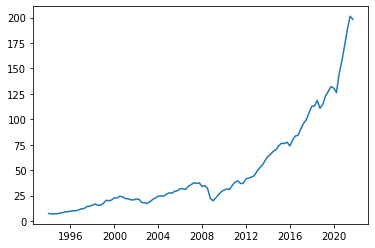

In [67]:
bench = prices.groupby(["year","quarter"]).mean().reset_index()
bench["date"] = [datetime(int(row[1]["year"]),int(row[1]["quarter"])* 3 - 2, 1) for row in bench.iterrows()]
plt.plot(bench["date"],bench["adjClose"])

In [66]:
bench.dropna()

,year,quarter,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,week
0,1994,1,39.341907,39.760567,38.903183,39.358177,4.611625e+05,7.412547,7.494414,7.330253,7.417562,3.700045e+06,0.003046,1.000393,6.916751
1,1994,2,35.742186,36.135972,35.323656,35.747406,4.520150e+05,6.979594,7.058437,6.895517,6.981273,3.382731e+06,0.003156,1.001059,19.928928
2,1994,3,35.250693,35.577259,34.892368,35.228920,4.314814e+05,7.099838,7.167914,7.025144,7.096063,3.092686e+06,0.002871,1.000336,32.937500
3,1994,4,34.739586,35.102177,34.395582,34.747571,4.586082e+05,7.128407,7.204947,7.056432,7.129954,3.307132e+06,0.007212,1.000208,45.911583
4,1995,1,36.034321,36.351339,35.660030,35.980736,4.985469e+05,7.550618,7.618656,7.471058,7.540619,3.706665e+06,0.002947,1.000232,7.083480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2020,4,161.534315,163.674529,159.513166,161.608712,4.940335e+06,157.866181,159.960792,155.885080,157.935546,4.841831e+06,0.007096,1.000149,46.597072
108,2021,1,175.870716,178.337034,173.389313,175.864405,5.199009e+06,172.871290,175.297572,170.428676,172.863866,5.122672e+06,0.007192,1.000033,6.868852
109,2021,2,190.434453,192.274926,188.457818,190.401269,4.316020e+06,188.654215,190.476325,186.701895,188.625651,4.287009e+06,0.007110,1.000129,19.669538
110,2021,3,201.899193,203.846988,199.875110,201.894827,3.950479e+06,201.367934,203.309234,199.349445,201.362454,3.931267e+06,0.007752,1.000088,32.731551


In [95]:
overhead = []
for category_training_year in tqdm(range(1,5)):
    for model_training_year in tqdm(range(3,6)):
        current_sim = sim[(sim["model_training_year"]==model_training_year) & (sim["category_training_year"]==category_training_year)]
        final_sim = prices.merge(current_sim,on=["year","quarter","ticker"],how="left").dropna().reset_index()
        final_sim = final_sim[["year","quarter","date","ticker","adjClose","quarterly_price_regression_prediction","score"]]
        report = {}
        report["cty"] = category_training_year
        report["mty"] = model_training_year
        report["avail_tick"] = len(final_sim["ticker"].unique())
        report["r2"] = r2_score(final_sim["quarterly_price_regression_prediction"],final_sim["adjClose"])
        report["mape"] = mean_absolute_percentage_error(final_sim["quarterly_price_regression_prediction"],final_sim["adjClose"])
        report["start_date"] = final_sim["date"].min()
        report["end_date"] = final_sim["date"].max()
        overhead.append(report)
        analysis = final_sim.groupby("date").mean().reset_index()
#         plt.plot(analysis["date"],analysis["quarterly_price_regression_prediction"])
#         plt.plot(analysis["date"],analysis["adjClose"])
#         plt.title(f'CTY: {category_training_year} | MTY: {model_training_year}')
#         plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.26s/it]


In [96]:
oh = pd.DataFrame(overhead)
oh["percentage_ticks"] = oh["avail_tick"] / 500
oh["score"] = oh["percentage_ticks"] * 0.2 + oh["r2"]*0.4 + oh["mape"]*0.4
oh.sort_values("score",ascending=False)

,cty,mty,avail_tick,r2,mape,start_date,end_date,percentage_ticks,score
8,3,5,425,0.826614,0.518765,2018-01-02 00:00:00+00:00,2021-06-30 00:00:00+00:00,0.850,0.708152
3,2,3,391,0.615476,0.666897,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.782,0.669349
6,3,3,404,0.842094,0.417924,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.808,0.665607
4,2,4,383,0.632511,0.633226,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.766,0.659495
11,4,5,449,0.753386,0.399326,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.898,0.640685
0,1,3,376,0.817593,0.372013,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.752,0.626242
9,4,3,432,0.640388,0.411754,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.864,0.593657
1,1,4,321,0.758334,0.349174,2018-04-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.642,0.571403
10,4,4,422,0.605921,0.392081,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.844,0.568001
5,2,5,408,0.624911,0.382795,2018-01-02 00:00:00+00:00,2021-09-30 00:00:00+00:00,0.816,0.566283


In [27]:
analysis = []
for ticker in tqdm(prices["ticker"].unique()):
    ticker_data = prices[prices["ticker"]==ticker]
    ticker_data.sort_values("date",ascending=True,inplace=True)
    ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
    ticker_data["date_delta"] = [x.days for x in ticker_data["date_delta"]]
    avg_delta = ticker_data["date_delta"].mean()
    max_delta = ticker_data["date_delta"].max()
    strange_dates = list(ticker_data[ticker_data["date_delta"]>=max_delta]["date"])
    analysis.append({"ticker":ticker,"avg_delta":avg_delta,"max_delta":max_delta,"strange_dates":strange_dates})

  0%|                                                                                                                                           | 0/500 [00:00<?, ?it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  1%|█▌                                                                                                                                 | 6/500 [00:02<02:58,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  2%|███                                                                                                                               | 12/500 [00:04<02:58,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  4%|████▋                                                                                                                             | 18/500 [00:06<02:54,  2.76it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  5%|██████▏                                                                                                                           | 24/500 [00:08<02:48,  2.82it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  6%|███████▊                                                                                                                          | 30/500 [00:10<02:48,  2.79it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  7%|█████████▎                                                                                                                        | 36/500 [00:12<02:47,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

  8%|██████████▉                                                                                                                       | 42/500 [00:15<02:46,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 10%|████████████▍                                                                                                                     | 48/500 [00:17<02:42,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 11%|██████████████                                                                                                                    | 54/500 [00:19<02:42,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 12%|███████████████▌                                                                                                                  | 60/500 [00:21<02:42,  2.71it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 13%|█████████████████▏                                                                                                                | 66/500 [00:23<02:39,  2.72it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 14%|██████████████████▋                                                                                                               | 72/500 [00:26<02:35,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 16%|████████████████████▎                                                                                                             | 78/500 [00:28<02:33,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 17%|█████████████████████▊                                                                                                            | 84/500 [00:30<02:30,  2.76it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 18%|███████████████████████▍                                                                                                          | 90/500 [00:32<02:25,  2.83it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 19%|████████████████████████▉                                                                                                         | 96/500 [00:34<02:25,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 20%|██████████████████████████▎                                                                                                      | 102/500 [00:37<02:21,  2.81it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 22%|███████████████████████████▊                                                                                                     | 108/500 [00:39<02:22,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 23%|█████████████████████████████▍                                                                                                   | 114/500 [00:41<02:58,  2.16it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 24%|██████████████████████████████▉                                                                                                  | 120/500 [00:43<02:21,  2.69it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 25%|████████████████████████████████▌                                                                                                | 126/500 [00:46<02:18,  2.69it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 26%|██████████████████████████████████                                                                                               | 132/500 [00:48<02:12,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 28%|███████████████████████████████████▌                                                                                             | 138/500 [00:50<02:14,  2.69it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 29%|█████████████████████████████████████▏                                                                                           | 144/500 [00:52<02:06,  2.82it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 30%|██████████████████████████████████████▋                                                                                          | 150/500 [00:54<02:03,  2.83it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 31%|████████████████████████████████████████▏                                                                                        | 156/500 [00:57<02:08,  2.68it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 32%|█████████████████████████████████████████▊                                                                                       | 162/500 [00:59<02:05,  2.69it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 34%|███████████████████████████████████████████▎                                                                                     | 168/500 [01:01<02:04,  2.66it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 35%|████████████████████████████████████████████▉                                                                                    | 174/500 [01:03<01:58,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 36%|██████████████████████████████████████████████▍                                                                                  | 180/500 [01:05<01:53,  2.81it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 37%|███████████████████████████████████████████████▉                                                                                 | 186/500 [01:07<01:51,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 38%|█████████████████████████████████████████████████▌                                                                               | 192/500 [01:10<01:52,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 40%|███████████████████████████████████████████████████                                                                              | 198/500 [01:12<01:48,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 41%|████████████████████████████████████████████████████▋                                                                            | 204/500 [01:14<01:46,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 42%|██████████████████████████████████████████████████████▏                                                                          | 210/500 [01:16<01:43,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 43%|███████████████████████████████████████████████████████▋                                                                         | 216/500 [01:18<01:43,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 44%|█████████████████████████████████████████████████████████▎                                                                       | 222/500 [01:20<01:42,  2.71it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 46%|██████████████████████████████████████████████████████████▊                                                                      | 228/500 [01:23<01:39,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 47%|████████████████████████████████████████████████████████████▎                                                                    | 234/500 [01:25<01:36,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 240/500 [01:27<01:34,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 246/500 [01:29<01:31,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 50%|█████████████████████████████████████████████████████████████████                                                                | 252/500 [01:31<01:31,  2.72it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 258/500 [01:33<01:26,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 53%|████████████████████████████████████████████████████████████████████                                                             | 264/500 [01:36<01:26,  2.73it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 270/500 [01:38<01:25,  2.69it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 276/500 [01:40<01:21,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 282/500 [01:42<01:17,  2.82it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 288/500 [01:44<01:15,  2.81it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 294/500 [01:47<01:14,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 300/500 [01:49<01:11,  2.81it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 306/500 [01:51<01:10,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 312/500 [01:53<01:10,  2.68it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 318/500 [01:55<01:04,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 324/500 [01:57<01:03,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 330/500 [02:00<01:00,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 336/500 [02:02<00:58,  2.82it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 342/500 [02:04<00:57,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 348/500 [02:06<00:54,  2.81it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 354/500 [02:08<00:52,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 360/500 [02:10<00:50,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 366/500 [02:13<00:47,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 372/500 [02:15<00:46,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 378/500 [02:17<00:44,  2.72it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                              | 384/500 [02:19<00:41,  2.77it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 390/500 [02:21<00:39,  2.76it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 396/500 [02:24<00:38,  2.72it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 402/500 [02:26<00:35,  2.76it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 408/500 [02:28<00:33,  2.74it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 414/500 [02:30<00:31,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 420/500 [02:32<00:29,  2.70it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 426/500 [02:35<00:27,  2.71it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 432/500 [02:37<00:24,  2.80it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 438/500 [02:39<00:22,  2.76it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 444/500 [02:41<00:20,  2.75it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 450/500 [02:43<00:18,  2.78it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 456/500 [02:45<00:15,  2.79it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 462/500 [02:48<00:15,  2.44it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 468/500 [02:50<00:12,  2.64it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 474/500 [02:52<00:09,  2.76it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 480/500 [02:54<00:07,  2.71it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 486/500 [02:57<00:05,  2.62it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 492/500 [02:59<00:02,  2.79it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [03:01<00:00,  2.81it/s]C:\Users\ericj\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\ericj\AppData\Local\Temp/ipykernel_10216/418141083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["date_delta"] = ticker_data["date"].shift(-1)-ticker_data["date"]
C:\Users\ericj\AppData\Local\Temp/ipykernel

In [37]:
a = pd.DataFrame(analysis)
a.sort_values("max_delta",ascending=False)
date_analysis = []
for row in a.iterrows():
    dates = row[1]["strange_dates"]
    days = row[1]["max_delta"]
    for d in dates:
        date_analysis.append({"date":d,"count":1,"days":days})

In [94]:
da = pd.DataFrame(date_analysis)
time_reference = "month"
da["month"] = [x.month for x in da["date"]]
da["week"] = [x.week for x in da["date"]]
dc = da.groupby(time_reference).sum().reset_index()[[time_reference,"count"]]
dd = da.groupby(time_reference).mean().reset_index()[[time_reference,"days"]]
d = dc.merge(dd,on=time_reference,how="left")
d.sort_values("count",ascending=False).head(50)

,month,count,days
7,9,543,6.093923
9,12,291,4.140893
4,5,243,4.061728
1,2,230,4.000000
0,1,229,4.000000
3,4,179,4.000000
5,7,144,4.000000
6,8,92,4.000000
8,10,78,5.000000
2,3,58,4.000000


In [54]:
dd

,week,days,month,week
0,2,4.000000,1.000000,2
1,3,4.000000,1.000000,3
2,6,4.000000,2.000000,6
3,7,4.000000,2.000000,7
4,12,4.000000,3.000000,12
5,13,4.000000,3.560000,13
6,14,4.000000,4.000000,14
7,15,4.000000,4.000000,15
8,16,4.000000,4.000000,16
9,19,19.000000,5.000000,19


In [79]:
market.connect()
uf = market.retrieve("unified_financials")
market.disconnect()

In [81]:
for i in range(31):
    uf.drop(str(i),axis=1,errors="ignore",inplace=True)

In [87]:
fin_an = prices.groupby(["year","quarter","ticker"]).mean().reset_index().merge(uf,on=["year","quarter","ticker"],how="left").dropna()
fin_an.drop(["close","high","low","open","volume","adjHigh","adjLow","adjOpen","adjVolume","divCash","splitFactor","_id","week"],axis=1,inplace=True)

In [93]:
# import seaborn as sns
# %matplotlib inline

# # calculate the correlation matrix
# corr = fin_an.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)
fin_an.corr()["adjClose"]

year                                               0.239841
quarter                                           -0.014197
adjClose                                           1.000000
AccumulatedOtherComprehensiveIncomeLossNetOfTax   -0.016965
Assets                                            -0.013775
AssetsCurrent                                      0.139510
CashAndCashEquivalentsAtCarryingValue              0.040041
EarningsPerShareBasic                             -0.007172
EarningsPerShareDiluted                           -0.003299
EntityCommonStockSharesOutstanding                -0.004574
IncomeTaxExpenseBenefit                            0.019010
LiabilitiesAndStockholdersEquity                  -0.015558
LiabilitiesCurrent                                 0.104994
NetIncomeLoss                                      0.066301
OtherAssetsNoncurrent                              0.062800
RetainedEarningsAccumulatedDeficit                 0.044142
StockholdersEquity                      